# Creating a Dendrogram

In [1]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import regex as re

def tree(alignment, graph_type="single"):
    tree_dict = {"Chain 1" : [],
                 "Chain 2": [],
                 "Chain 1 TM Score" : [],
                 "Chain 2 TM Score" : [],
                 "Average TM Score" : []}
    # for each pairwise alignment, average the TM scores
    with open(alignment, 'r') as f:
        alignments = f.readlines()
        for line in alignments:
            line = line.strip()
            if "Name" in line:
                if "Chain_1" in line: 
                    tree_dict["Chain 1"].append(line.split(":")[1].strip())
                else: tree_dict["Chain 2"].append(line.split(":")[1].strip())
            if "TM-score=" in line:
                if "Chain_1" in line: tree_dict["Chain 1 TM Score"].append(float(line.split()[1]))
                else: 
                    tree_dict["Chain 2 TM Score"].append(float(line.split()[1]))
                    tree_dict["Average TM Score"].append((tree_dict["Chain 1 TM Score"][-1] + tree_dict["Chain 2 TM Score"][-1]) / 2)
    tree = pd.DataFrame(tree_dict)
    tree["Merged"] = "(" + tree["Chain 1"] + "," + tree["Chain 2"] + ")"

    dist_matrix = pd.DataFrame(index = tree["Chain 1"].unique(), columns = tree["Chain 1"].unique())

    # Create distance matrix
    for i in range(tree.shape[0]):
        dist_matrix.loc[tree.iloc[i, 0], tree.iloc[i, 1]] = tree.iloc[i, 4]
    dist_matrix = dist_matrix.fillna(0)

    # Create tree
    if graph_type == "all":
        for j in ["single", "complete", "centroid"]:
            plt.figure(figsize=(20, 20))
            linkage_matrix = linkage(dist_matrix, j)           
            dendro = dendrogram(linkage_matrix, 
                       color_threshold=2, 
                       labels=tree.iloc[:,1].unique(), 
                       get_leaves=True,
                       leaf_rotation=90,
                       truncate_mode='level', 
                       p = 10) 

            # Color experimental structures
            labels = plt.gca().get_xmajorticklabels()
            for label in labels:
                if 'VPC' not in label.get_text():
                    label.set_color('red')
                else:
                    label.set_color('black')            
            plt.title(j)
            plt.ylabel("Average TM Score")
            plt.xticks(rotation=65, ha='right', fontsize=10)
            plt.show()
            leaves = dendro["ivl"]
            count = 65
            out = []
            for l in leaves:
                if l.startswith("("):
                    out.append(chr(count) + l)
                    count += 1
            else:
                out.append(l)
            # plt.savefig(j + ".png")
    else:
        plt.figure(figsize=(20, 20))
        linkage_matrix = linkage(dist_matrix, graph_type)
        dendro  = dendrogram(linkage_matrix, 
                    color_threshold=2, 
                    labels=tree.iloc[:,1].unique(), 
                    get_leaves=True,
                    leaf_rotation=90) 
        # Color experimental structures
        labels = plt.gca().get_xmajorticklabels()
        for label in labels:
            # if VPC not in label and label doesn't start with "("
            if 'VPC' not in label.get_text() and label.get_text()[0] != "(":
                label.set_color('red')
            else:
                label.set_color('black')            
        plt.title(graph_type)
        plt.ylabel("Average TM Score")
        plt.xticks(rotation=90, ha='right', fontsize=10)
        plt.show()

        # print out leaves 
        leaves = dendro["ivl"]
        count = 65
        out = []
        for l in leaves:
            if l.startswith("("):
                out.append(chr(count) + l)
                count += 1
        else:
            out.append(l)
    return(tree, dist_matrix, out)


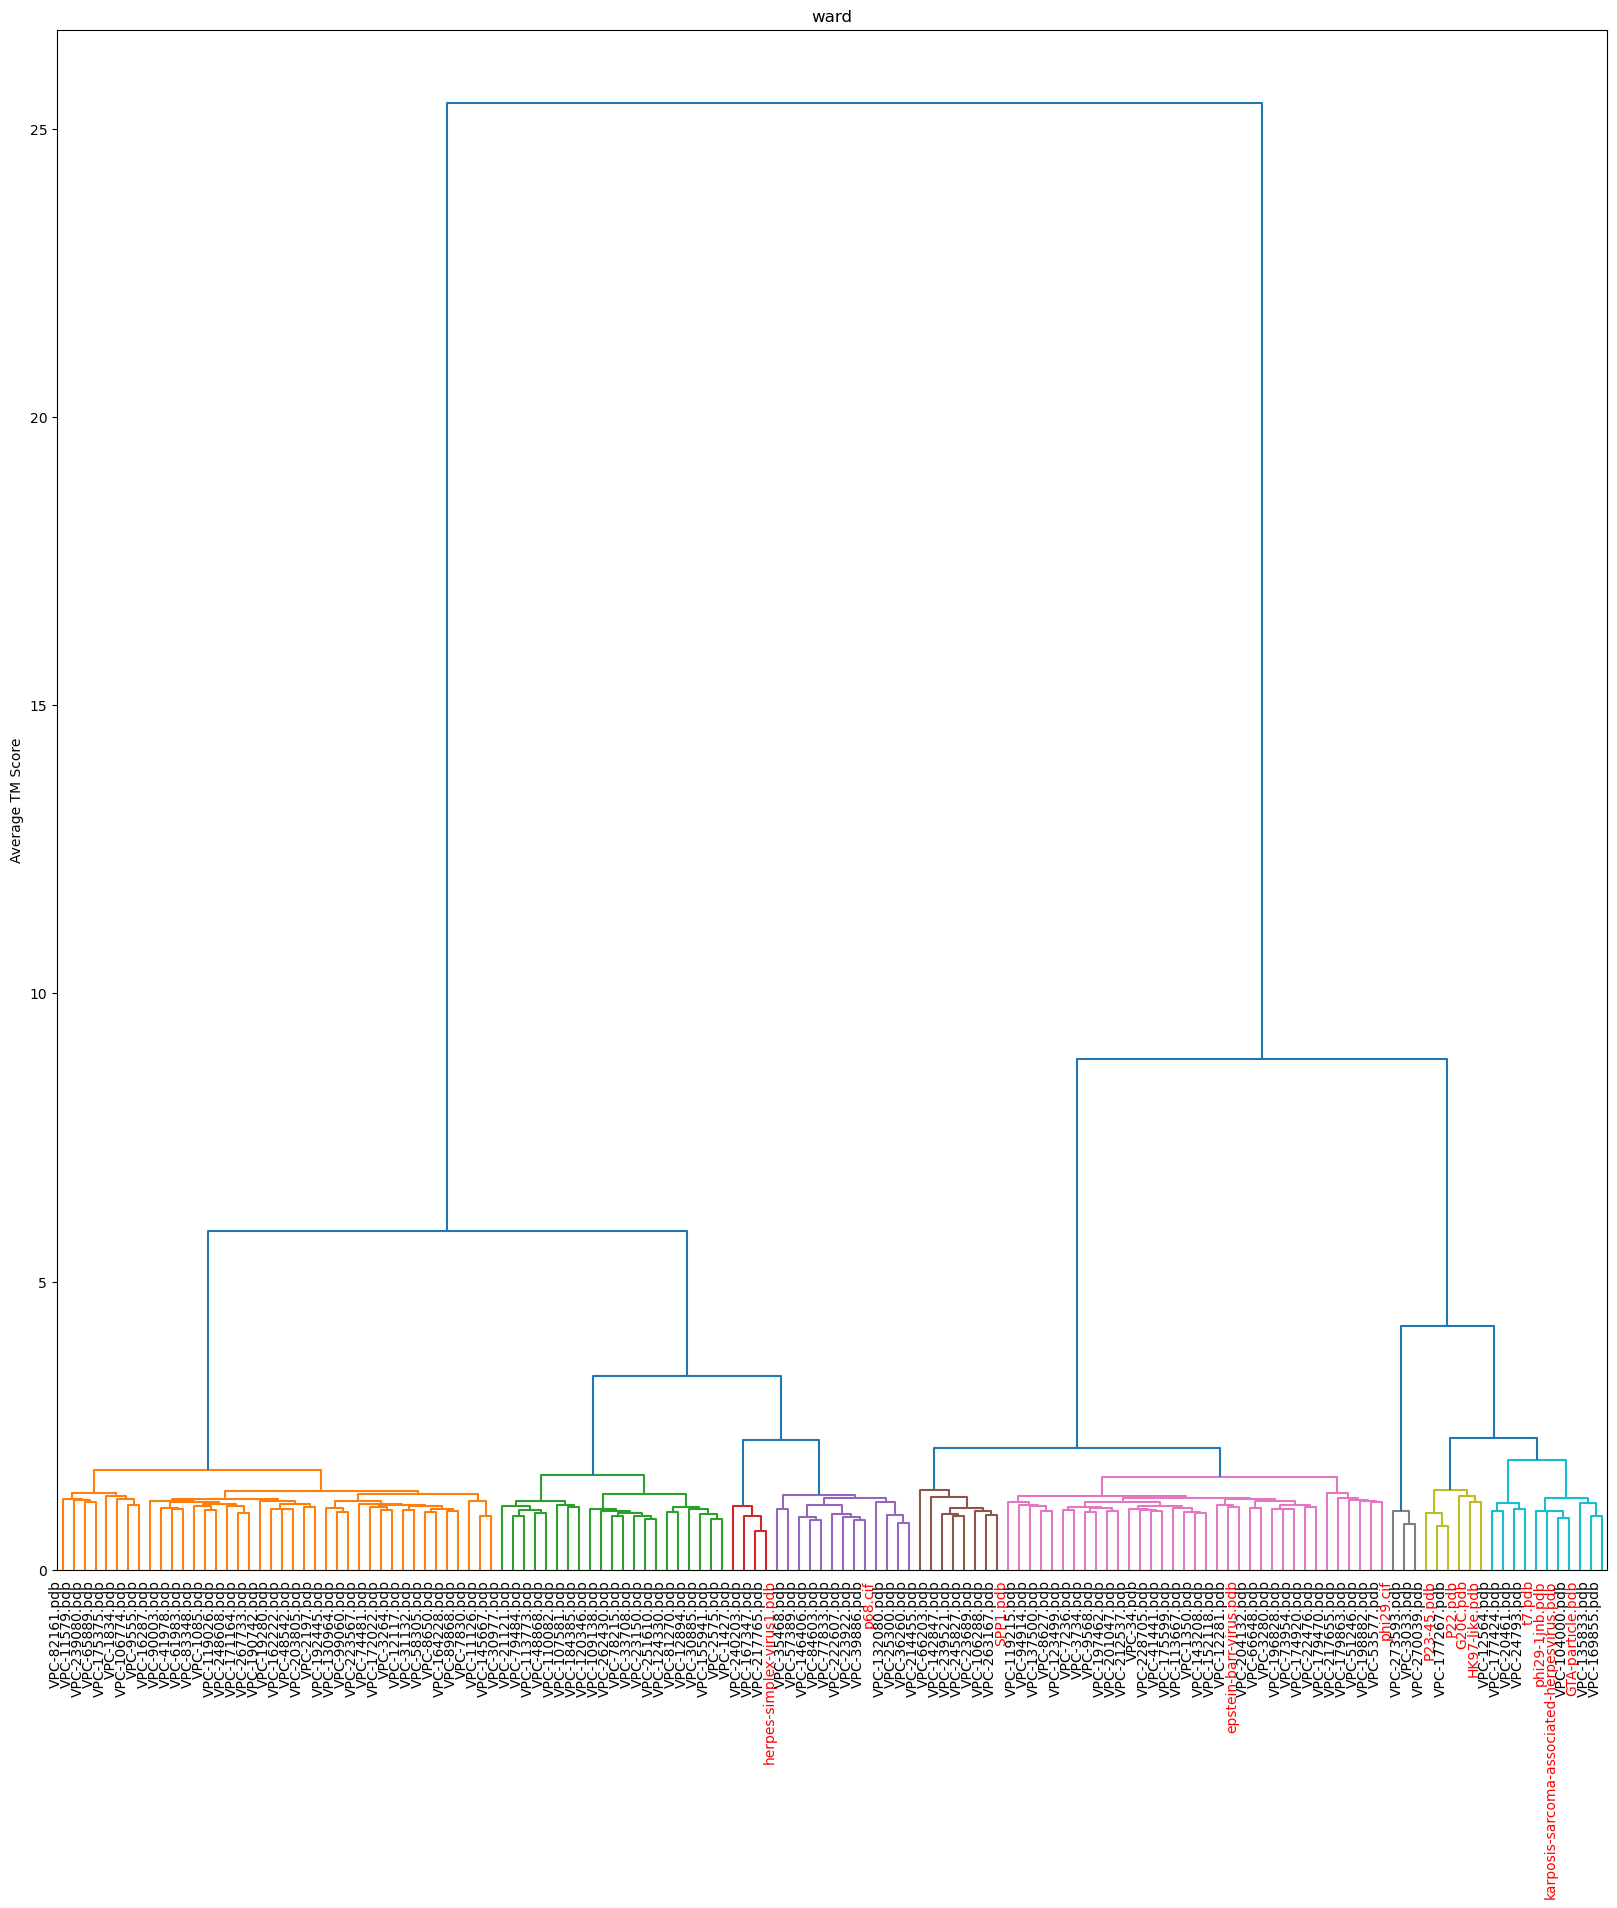

In [2]:
aln_file = "scores.txt"
tree, dist_matrix, out = tree(aln_file, "ward")

In [3]:
import regex as re

def get_most_common(dendro, full_dendro):
    full_leaves = full_dendro["ivl"]
    leaves = dendro["ivl"]
    # label merged leaves with a letter
    count = 65
    out = {}
    for l in leaves:
        if l.startswith("("):
            k = (chr(count) + l)
            out[k] = []
            count += 1
        else:
            out[l] = []
    ind = 0
    for i in out.keys():
        if "(" in i:
            num = int(re.findall('\d+', i)[0]) # number of leaves that have been merged
            for j in range(0, num):
                out[i].append(full_leaves[ind])
                ind += 1
        else:
            ind += 1 
    family = pd.read_csv("vpc_family.csv") 
    family = family[["VPC", "ictv_family"]].dropna()
    # count occurences of each unique item in "ictv_family"
    family = family.set_index("VPC")
    family_dict = family.to_dict()["ictv_family"]
    
    # get most common family for each VPC or known structure
    out_family = {}
    for key, value in out.items():
        if "VPC" in key:
            try:
                out_family[key] = family_dict[re.findall(r"VPC-\d+", key)[0]]
            except:
                pass
        else:
            out_family[key] = []
            for i in value:
                try: out_family[key].append(family_dict[i.split(".")[0]])
                except: pass
            out_family[key] = pd.Series(out_family[key]).value_counts().to_dict()

    
    # get most common family in each merged cluster
    most_common = {}
    for key, value in out_family.items():
        if "VPC" in key:
            most_common[key] = value
        else:
            if value == {}:
                most_common[key] = "unknown"
            else:
                keymax = max(zip(value.values(), value.keys()))[1]
                most_common[key] = keymax
    return out, family_dict, out_family, most_common


# Plot dendrogram with family annotations

In [4]:
def plot_dendrogram(dist_matrix, method="ward", full=True, mode="lastp", p=30):
  plt.figure(figsize=(20, 20))
  linkage_matrix = linkage(dist_matrix, method)
  if full:
    dendro  = dendrogram(linkage_matrix, 
                color_threshold=2, 
                labels=tree.iloc[:,1].unique(), 
                get_leaves=True,
                leaf_rotation=90)
    out, family_dict, out_family, most_common = get_most_common(dendro, dendro)
  else:
    full_dendro  = dendrogram(linkage_matrix, 
            color_threshold=2, 
            labels=tree.iloc[:,1].unique(), 
            get_leaves=True,
            leaf_rotation=90)
    dendro  = dendrogram(linkage_matrix, 
                color_threshold=2, 
                labels=tree.iloc[:,1].unique(), 
                get_leaves=True,
                leaf_rotation=90, 
                truncate_mode=mode, 
                p = p)
    out, family_dict, out_family, most_common = get_most_common(dendro, full_dendro)
  
  # Color experimental structures
  labels = plt.gca().get_xmajorticklabels()
  count = 65
  k = ""
  for i, label in enumerate(labels): 
    # if VPC not in label and label doesn't start with "("
    if label.get_text().startswith("("):
      k = (chr(count) + label.get_text())
      count += 1
      labels[i] = k
    if 'VPC' not in label.get_text() and label.get_text()[0] != "(":
        label.set_color('red')
    elif label.get_text()[0] != "(":
      try:
        if most_common[label.get_text()] == "Siphoviridae":
          label.set_color('blue')
        elif most_common[label.get_text()] == "Podoviridae":
          label.set_color('green')
      except:
        label.set_color('black')  
    elif label.get_text()[0] == "(":
      try:
        if most_common[k] == "Siphoviridae":
          label.set_color('blue')
        elif most_common[k] == "Podoviridae":
          label.set_color('green')
      except:
        label.set_color('black')   
    # else:
    #     label.set_color('black')            
  plt.title("ward")
  plt.ylabel("Average TM Score")
  plt.xticks(rotation=90, ha='right', fontsize=10)
  plt.show()

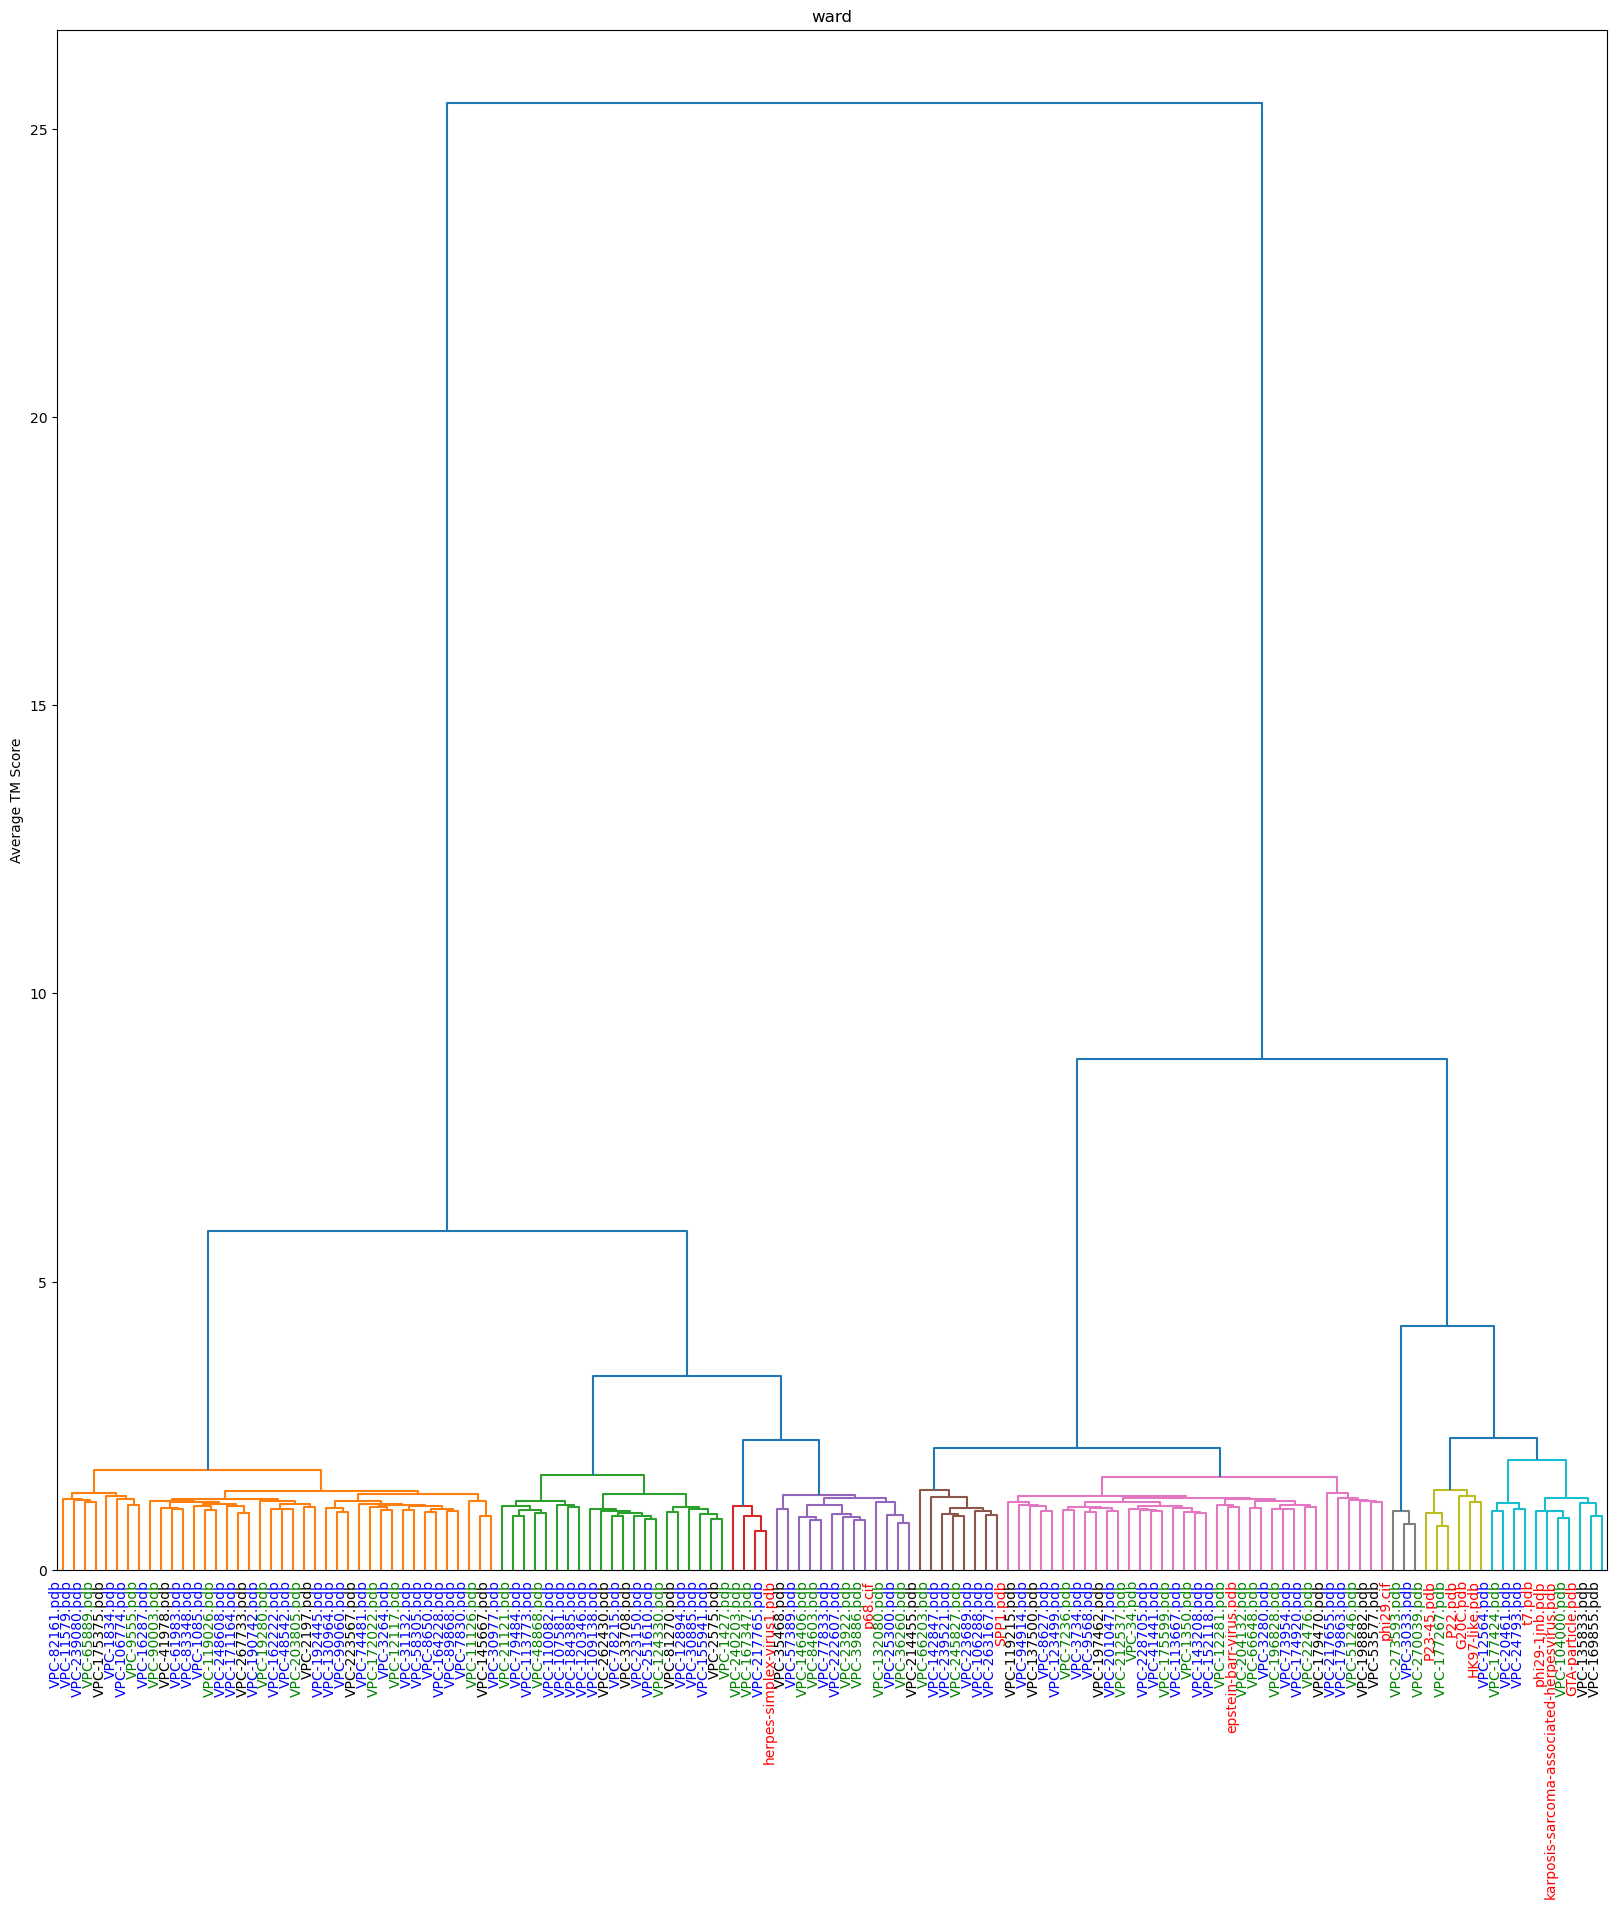

In [5]:
# Full
plot_dendrogram(dist_matrix)

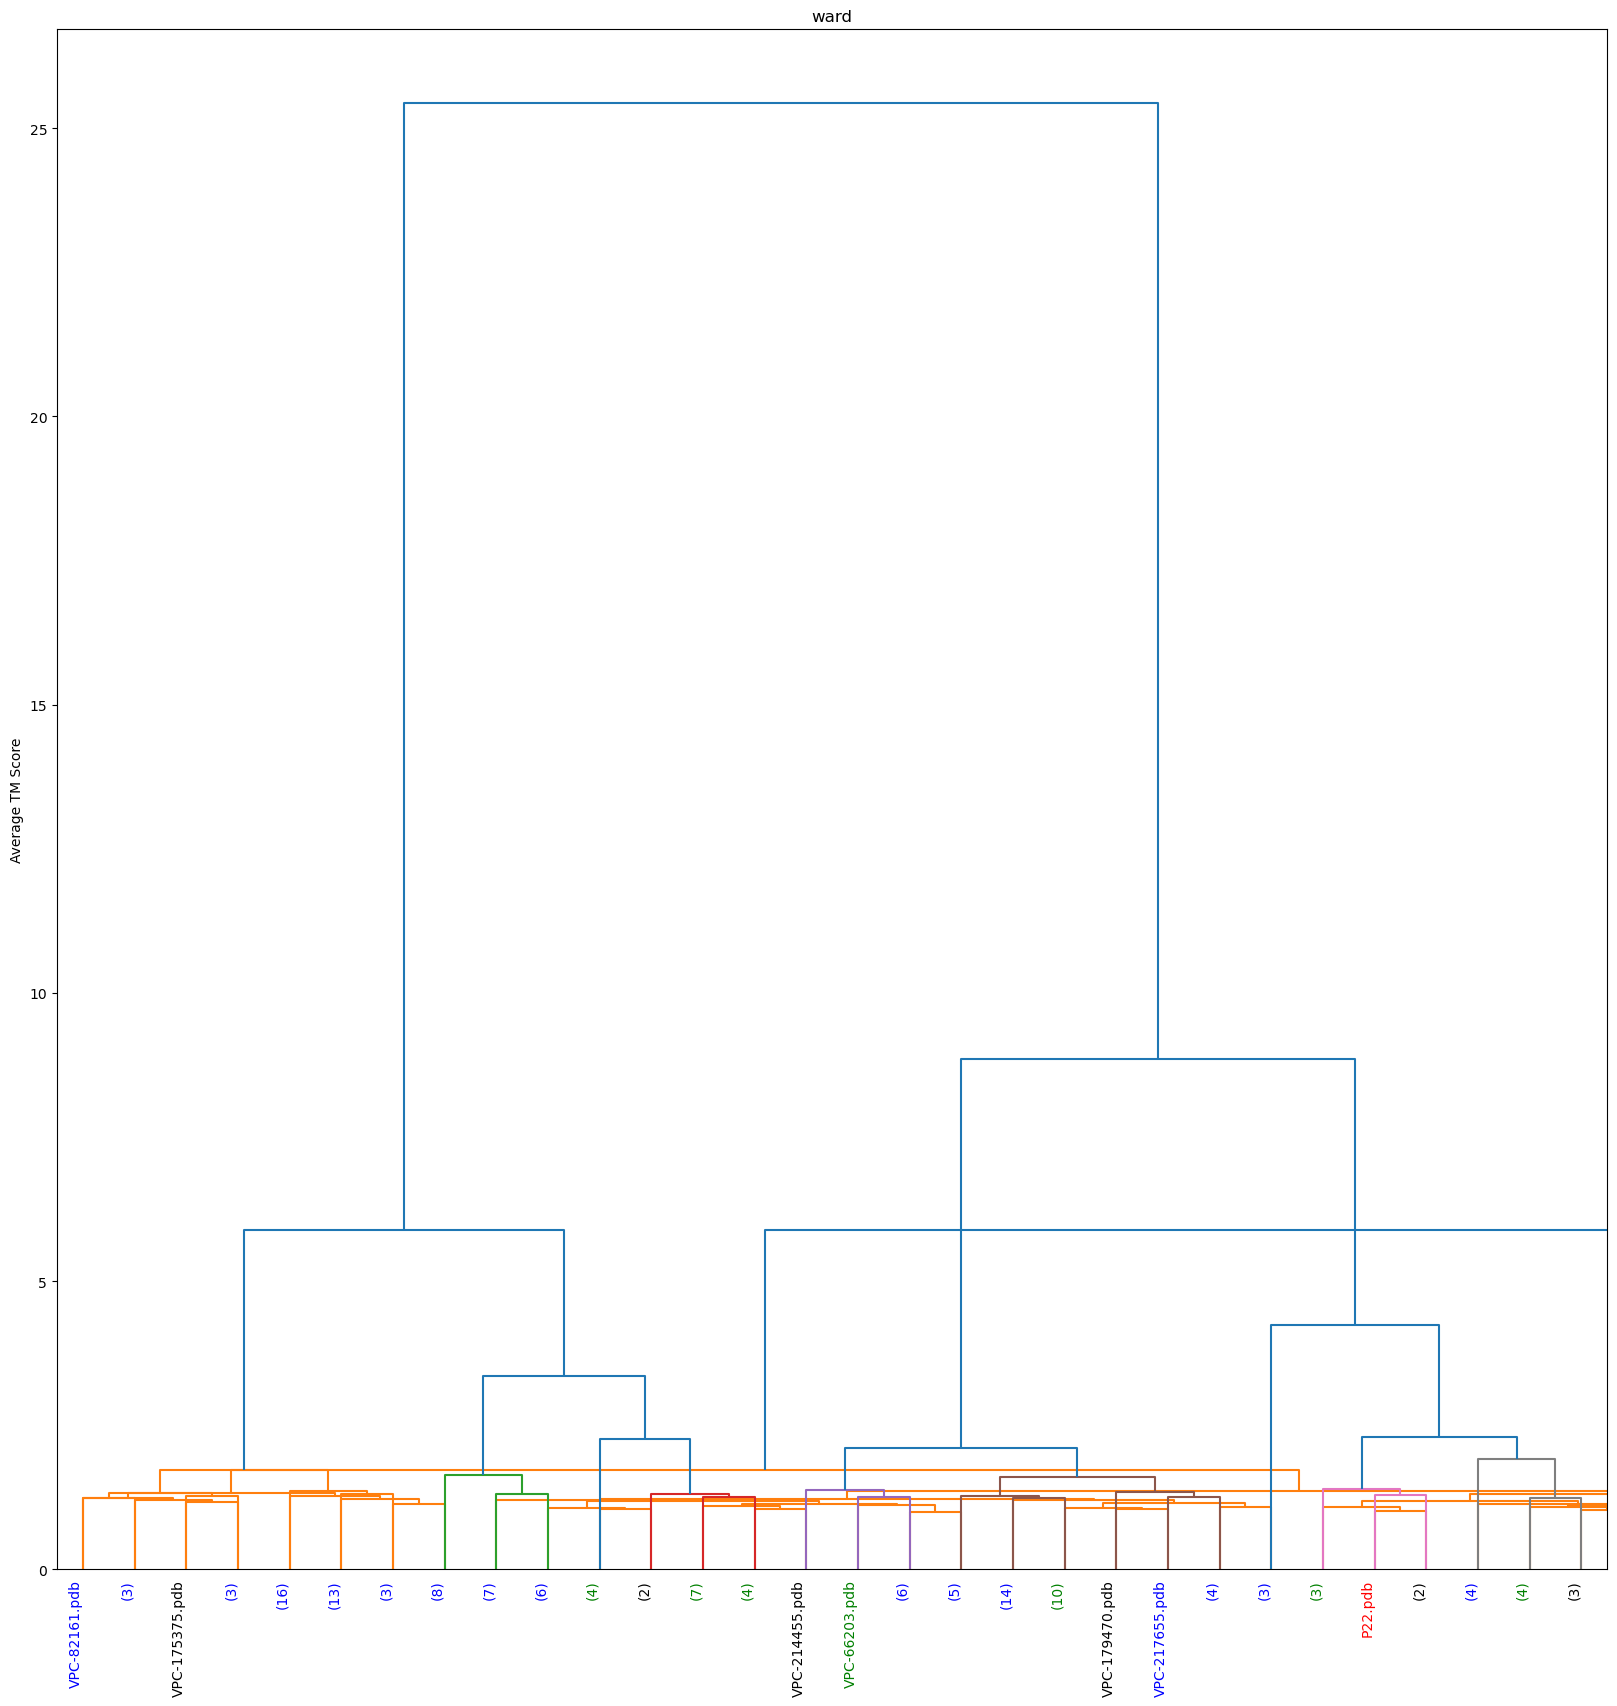

In [6]:
# Truncated
plot_dendrogram(dist_matrix, full=False)